In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '22'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20230415SATFB0002', '2023-Apr-15', '00:30:00', 'Italian Division 1 [ISA]', 'Cremonese', 'Empoli', 'true', '9.5', '1.83', '1.87', 'false', '10.5', '2.30', '1.54', 'false', '13.5', '5.10', '1.12']
['20230415SATFB9995', '2023-Apr-15', '00:30:00', 'German Division 2 [GD2]', 'Hannover', 'Heidenheim', 'true', '9.5', '1.75', '1.95', 'false', '10.5', '2.20', '1.59', 'false', '13.5', '5.10', '1.12']
['20230415SATFB9996', '2023-Apr-15', '00:30:00', 'German Division 2 [GD2]', 'Greuther Furth', 'Jahn Regensburg', 'true', '9.5', '2.08', '1.66', 'false', '10.5', '2.70', '1.40', 'false', '12.5', '4.90', '1.13']
['20230415SATFB9991', '2023-Apr-15', '02:30:00', 'German Division 1 [GSL]', 'Schalke 04', 'Hertha Berlin', 'true', '9.5', '1.73', '1.98', 'false', '10.5', '2.17', '1.61', 'false', '12.5', '3.45', '1.25']
['20230415SATFB0001', '2023-Apr-15', '02:45:00', 'Italian Division 1 [ISA]', 'Spezia', 'Lazio', 'true', '10.5', '2.20', '1.59', 'false', '11.5', '2.82', '1.37', 'false', '13.5', '5.10', '1.1

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [13]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [14]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20230415SATFB0002,2023-Apr-15,00:30:00,Italian Division 1 [ISA],Cremonese,Empoli,true,9.5,1.83,1.87,false,10.5,2.30,1.54,false,13.5,5.10,1.12
1,20230415SATFB9995,2023-Apr-15,00:30:00,German Division 2 [GD2],Hannover,Heidenheim,true,9.5,1.75,1.95,false,10.5,2.20,1.59,false,13.5,5.10,1.12
2,20230415SATFB9996,2023-Apr-15,00:30:00,German Division 2 [GD2],Greuther Furth,Jahn Regensburg,true,9.5,2.08,1.66,false,10.5,2.70,1.40,false,12.5,4.90,1.13
3,20230415SATFB9991,2023-Apr-15,02:30:00,German Division 1 [GSL],Schalke 04,Hertha Berlin,true,9.5,1.73,1.98,false,10.5,2.17,1.61,false,12.5,3.45,1.25
4,20230415SATFB0001,2023-Apr-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,true,10.5,2.20,1.59,false,11.5,2.82,1.37,false,13.5,5.10,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,20230417MONFB0142,2023-Apr-17,07:00:00,Mexican Premier [MXL],Queretaro,Tigres UANL,true,9.5,2.08,1.66,false,10.5,2.70,1.40,false,12.5,4.75,1.14
117,20230417MONFB0141,2023-Apr-17,09:05:00,Mexican Premier [MXL],Monterrey,Santos Laguna,true,10.5,1.98,1.73,false,11.5,2.55,1.45,false,13.5,4.05,1.19
118,20230418TUEFB0197,2023-Apr-18,02:45:00,Italian Division 1 [ISA],Fiorentina,Atalanta,true,9.5,1.83,1.87,false,10.5,2.30,1.54,false,13.5,5.30,1.11
119,20230418TUEFB0013,2023-Apr-18,03:00:00,Eng Premier [EPL],Leeds,Liverpool,true,10.5,2.05,1.68,false,11.5,2.65,1.42,false,13.5,4.55,1.15


In [15]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [16]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [17]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [18]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [19]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [20]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [21]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [22]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [23]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [24]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [25]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [26]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [27]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [28]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [29]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [30]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [31]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [33]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB0002,SATFB0001,SATFB0092,SUNFB0093,SUNFB0089
Date,2023-04-15 00:00:00,2023-04-15 00:00:00,2023-04-15 00:00:00,2023-04-16 00:00:00,2023-04-16 00:00:00
Time,00:30:00,02:45:00,21:00:00,00:00:00,02:45:00
LeagueJC,Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA]
HomeTeamJC,Cremonese,Spezia,Bologna,Napoli,Inter Milan
AwayTeamJC,Empoli,Lazio,AC Milan,Verona,Monza
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,9.5,10.5,9.5,9.5,10.5
CHL_H_0,1.83,2.2,1.85,1.83,2.13
CHL_L_0,1.87,1.59,1.85,1.87,1.63


## Load model

In [34]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [35]:
to = load_pandas('models/to.pkl')

In [36]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [37]:
odds = odds.dropna(how='any')

In [38]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [39]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,I1,Cremonese,Empoli,11.4,2.8,10.4,4.2,11.6,12.6,12.0,15.0
1,I1,Spezia,Lazio,11.8,4.8,10.4,4.4,11.6,9.0,16.2,11.4
2,I1,Bologna,Milan,16.2,3.6,9.2,3.6,12.4,13.8,11.8,11.8
3,I1,Napoli,Verona,14.4,6.4,10.0,4.8,16.6,11.2,9.2,13.2
4,I1,Inter,Monza,16.4,5.0,7.8,2.0,17.8,11.8,11.0,10.8
5,I1,Lecce,Sampdoria,13.8,5.6,11.8,3.2,10.6,8.6,11.4,18.6
6,I1,Torino,Salernitana,12.4,5.2,8.2,3.4,10.4,10.8,12.2,14.2
7,I1,Sassuolo,Juventus,13.8,3.4,12.8,4.4,13.2,13.6,14.6,10.0
8,I1,Roma,Udinese,10.8,5.2,10.6,5.4,13.8,12.6,11.4,12.8
9,I1,Fiorentina,Atalanta,19.6,7.0,10.6,5.0,15.8,13.0,12.0,11.2


In [40]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [41]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [42]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [43]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [44]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [45]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [46]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [47]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB0002,2023-04-15,00:30:00,Italian Division 1 [ISA],Cremonese,Empoli,True,9.5,1.83,1.87,0.063625,0.057253,5.140981,5.264021,-47.788025,-0.087892
1,SATFB0001,2023-04-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,True,10.5,2.20,1.59,0.111491,0.093532,3.941321,4.630720,-42.693016,-0.162300
2,SATFB0092,2023-04-15,21:00:00,Italian Division 1 [ISA],Bologna,AC Milan,True,9.5,1.85,1.85,0.070779,0.096208,5.431334,4.304846,-45.434589,-0.133410
3,SUNFB0093,2023-04-16,00:00:00,Italian Division 1 [ISA],Napoli,Verona,True,9.5,1.83,1.87,0.061925,0.130349,6.769412,3.297379,-47.526539,-0.156926
4,SUNFB0089,2023-04-16,02:45:00,Italian Division 1 [ISA],Inter Milan,Monza,True,10.5,2.13,1.63,0.070553,0.086136,6.433851,3.561007,-44.498196,-0.117747


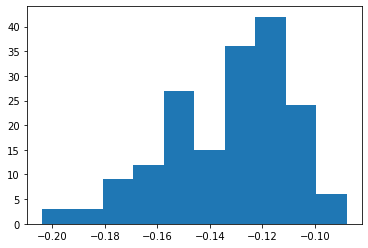

In [48]:
odds['corr'].hist(grid=False);

In [49]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [50]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [51]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [52]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [53]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [54]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [55]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [56]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [57]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
7,SATFB0001,2023-04-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,True,10.5,2.20,1.59,0.259058,0.740942,0.301860,Low,$$$
8,SUNFB0090,2023-04-16,18:30:00,Italian Division 1 [ISA],Lecce,Sampdoria,True,9.5,1.86,1.84,0.671835,0.328165,0.290247,High,$$
10,SUNFB0100,2023-04-16,20:00:00,Spanish Division 1 [SFL],Girona,CF Elche,True,9.5,2.08,1.66,0.284703,0.715297,0.283929,Low,$$
14,SATFB9991,2023-04-15,02:30:00,German Division 1 [GSL],Schalke 04,Hertha Berlin,True,9.5,1.73,1.98,0.373218,0.626782,0.245947,Low,$$
15,SUNFB0074,2023-04-16,19:30:00,German Division 2 [GD2],St. Pauli,Braunschweig,True,9.5,1.81,1.89,0.360775,0.639225,0.233860,Low,$$
16,SATFB0037,2023-04-15,21:30:00,German Division 1 [GSL],RB Leipzig,Augsburg,True,8.5,1.65,2.10,0.405036,0.594964,0.226750,Low,$$
18,MONFB0182,2023-04-17,02:45:00,Italian Division 1 [ISA],Roma,Udinese,True,10.5,2.13,1.63,0.572456,0.427544,0.194099,High,$
19,TUEFB0197,2023-04-18,02:45:00,Italian Division 1 [ISA],Fiorentina,Atalanta,True,9.5,1.83,1.87,0.378412,0.621588,0.186632,Low,$
21,SATFB9996,2023-04-15,00:30:00,German Division 2 [GD2],Greuther Furth,Jahn Regensburg,True,9.5,2.08,1.66,0.565283,0.434717,0.162767,High,$
25,SUNFB0097,2023-04-16,19:00:00,French Division 1 [FFL],Lille,Montpellier,True,8.5,1.74,1.97,0.625843,0.374157,0.120226,High,$


In [58]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SATFB9991,2023-04-15,02:30:00,German Division 1 [GSL],Schalke 04,Hertha Berlin,False,12.5,3.45,1.25,0.122758,0.877242,0.386208,Low,None
1,SATFB0001,2023-04-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,False,11.5,2.82,1.37,0.177623,0.822377,0.342316,Low,None
2,SATFB0001,2023-04-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,False,13.5,5.10,1.12,0.072905,0.927095,0.319549,Low,None
3,SUNFB0100,2023-04-16,20:00:00,Spanish Division 1 [SFL],Girona,CF Elche,False,10.5,2.70,1.40,0.194786,0.805214,0.318250,Low,None
4,SUNFB0100,2023-04-16,20:00:00,Spanish Division 1 [SFL],Girona,CF Elche,False,12.5,4.90,1.13,0.078898,0.921102,0.314191,Low,None
5,SATFB0037,2023-04-15,21:30:00,German Division 1 [GSL],RB Leipzig,Augsburg,False,11.5,3.55,1.24,0.133020,0.866980,0.312729,Low,None
6,SATFB0037,2023-04-15,21:30:00,German Division 1 [GSL],RB Leipzig,Augsburg,False,10.5,2.68,1.41,0.202362,0.797638,0.304073,Low,None
7,SATFB0001,2023-04-15,02:45:00,Italian Division 1 [ISA],Spezia,Lazio,True,10.5,2.20,1.59,0.259058,0.740942,0.301860,Low,$$$
8,SUNFB0090,2023-04-16,18:30:00,Italian Division 1 [ISA],Lecce,Sampdoria,True,9.5,1.86,1.84,0.671835,0.328165,0.290247,High,$$
9,SATFB9991,2023-04-15,02:30:00,German Division 1 [GSL],Schalke 04,Hertha Berlin,False,10.5,2.17,1.61,0.269881,0.730119,0.287691,Low,None


In [59]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)